# ARMA & ARMAX — Δlog(volume) **og** Δvolume (TEST)
*Generated:* 2025-10-23 08:23

Denne notatboken kjører rutenett av **ARMA(p,q)** og **ARMAX(p,q)** på to mål:
1) **Δlog(volume)** (vekstrater) — klassisk for stasjonaritet.
2) **Δvolume** (nivåendringer) — når du vil modellere vanlig volum direkte.

Begge modellene rekonstruerer **nivå-prognoser** for sammenligning mot faktisk volum.
Vi skriver kun ut tabeller og grafer (ingenting lagres til disk).


In [1]:
# --- Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


In [2]:
# --- Helper functions
def residual_diagnostics(resid, lags=24):
    r = pd.Series(resid).dropna()
    lb = acorr_ljungbox(r, lags=[lags], return_df=True)
    return {
        "eps_mean": float(r.mean()),
        "eps_std": float(r.std(ddof=1)),
        f"LjungBox_p(lag{lags})": float(lb["lb_pvalue"].iloc[-1]),
    }

def mae(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / denom)) * 100.0)

def adf_p(x):
    x = pd.Series(x).dropna()
    return adfuller(x, autolag="AIC")[1]


## Data

In [3]:
# --- Load train/test (expects columns: date, volume_all, + optional exogenous vars)
train = pd.read_csv("train_data.csv", parse_dates=["date"]).set_index("date").sort_index()
test  = pd.read_csv("test_data.csv",  parse_dates=["date"]).set_index("date").sort_index()

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  rows={len(train)}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}   rows={len(test)}")

# Targets / transforms
train['log_volume'] = np.log(train['volume_all'])
test['log_volume']  = np.log(test['volume_all'])

train['dlog'] = train['log_volume'].diff()
test['dlog']  = test['log_volume'].diff()

train['dlevel'] = train['volume_all'].diff()
test['dlevel']  = test['volume_all'].diff()

dlog_tr = train['dlog'].dropna()
dlog_te = test['dlog'].dropna()

dlev_tr = train['dlevel'].dropna()
dlev_te = test['dlevel'].dropna()

print("ADF p (Δlog train):", adf_p(dlog_tr))
print("ADF p (Δlevel train):", adf_p(dlev_tr))

# Keep last training values to reconstruct paths
last_log = train['log_volume'].iloc[-1]
last_level = train['volume_all'].iloc[-1]

# Exogenous (optional): numeric columns in both sets, excluding targets
exclude = {'volume_all','log_volume','dlog','dlevel'}
common_cols = [c for c in train.columns.intersection(test.columns) if c not in exclude]
exog_cols = [c for c in common_cols if np.issubdtype(train[c].dtype, np.number)]
print("Exogenous candidates:", exog_cols)

# Align exog to differenced series (drop first row)
Xtr_exog = train[exog_cols].iloc[1:].loc[dlog_tr.index] if exog_cols else None
Xte_exog = test[exog_cols].iloc[1:].loc[dlog_te.index] if exog_cols else None


Train: 2004-01-01 → 2022-12-30  rows=4957
Test:  2023-01-02  → 2025-10-08   rows=723
ADF p (Δlog train): 0.0
ADF p (Δlevel train): 2.3935443818277148e-30
Exogenous candidates: ['hist_vol', 'vix', 'log_hist_vol', 'log_vix']


## Funksjoner for rutenett (ARMA/ARMAX)

In [ ]:
def run_arma_grid(d_tr, d_te, reconstruct_func, family_label="ARMA", exog_tr=None, exog_te=None):
    p_list = [1,2,3,4]
    q_list = [0,1,2,3,4]
    rows = []
    models = {}
    forecasts_level = {}
    for p in p_list:
        for q in q_list:
            try:
                mdl = sm.tsa.SARIMAX(
                    d_tr, order=(p,0,q), trend='c',
                    exog=exog_tr,
                    enforce_stationarity=True,
                    enforce_invertibility=True
                ).fit(disp=False)
                h = len(d_te)
                fc = mdl.get_forecast(steps=h, exog=exog_te)
                d_pred = fc.predicted_mean
                level_pred, y_te_level = reconstruct_func(d_pred, h)
                mse  = float(np.mean((y_te_level - level_pred)**2))
                mae_ = float(np.mean(np.abs(y_te_level - level_pred)))
                mape_= float(np.nanmean(np.abs((y_te_level - level_pred)/y_te_level))*100)
                diag = residual_diagnostics(mdl.resid, lags=24)
                rows.append({
                    "family": family_label,
                    "p": p, "q": q, "model": f"{family_label}({p},{q})",
                    "AIC": float(mdl.aic),
                    "MSE(level)": mse, "MAE(level)": mae_, "MAPE(level)": mape_,
                    "LB_p(lag24)": diag["LjungBox_p(lag24)"]
                })
                models[(p,q)] = mdl
                forecasts_level[(p,q)] = (level_pred, y_te_level)
            except Exception:
                pass
    res = pd.DataFrame(rows).sort_values("AIC").reset_index(drop=True)
    return res, models, forecasts_level


## Rekonstruksjon til nivå

In [5]:
# Δlog → nivå
def reconstruct_from_dlog(dlog_pred, h):
    log_path = last_log + dlog_pred.cumsum()
    level_pred = np.exp(log_path)
    y_te_level = np.exp(test['log_volume'].iloc[:h])
    return level_pred, y_te_level

# Δlevel → nivå
def reconstruct_from_dlevel(dlevel_pred, h):
    level_path = last_level + dlevel_pred.cumsum()
    y_te_level = test['volume_all'].iloc[:h]
    return level_path, y_te_level


## ARMA på Δlog(volume) og Δlevel

In [6]:
arma_dlog_results, arma_dlog_models, arma_dlog_fc = run_arma_grid(
    dlog_tr, dlog_te, reconstruct_from_dlog, family_label="ARMA_dlog"
)
arma_dlev_results, arma_dlev_models, arma_dlev_fc = run_arma_grid(
    dlev_tr, dlev_te, reconstruct_from_dlevel, family_label="ARMA_dlevel"
)

display(arma_dlog_results.head())
display(arma_dlev_results.head())


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,family,p,q,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,ARMA_dlog,4,1,"ARMA_dlog(4,1)",-4943.249914,5.141796e+18,1.683591e+09,15.055209,7.904362e-11
1,ARMA_dlog,4,3,"ARMA_dlog(4,3)",-4940.447087,5.025183e+18,1.662612e+09,14.883895,3.332995e-18
2,ARMA_dlog,1,3,"ARMA_dlog(1,3)",-4931.165090,5.171022e+18,1.689274e+09,15.101842,6.562470e-14
3,ARMA_dlog,1,2,"ARMA_dlog(1,2)",-4928.358030,5.573434e+18,1.766600e+09,15.759236,5.909730e-15
4,ARMA_dlog,2,1,"ARMA_dlog(2,1)",-4926.383247,5.656777e+18,1.784545e+09,15.919038,6.258855e-15


,family,p,q,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,ARMA_dlevel,3,4,"ARMA_dlevel(3,4)",218997.997616,2.392216e+18,1.121614e+09,11.063896,2.433028e-02
1,ARMA_dlevel,4,4,"ARMA_dlevel(4,4)",219004.683635,2.921532e+18,1.260698e+09,11.880271,1.047458e-03
2,ARMA_dlevel,2,4,"ARMA_dlevel(2,4)",219019.249603,3.282401e+18,1.336258e+09,12.374885,6.831923e-07
3,ARMA_dlevel,4,3,"ARMA_dlevel(4,3)",219020.901308,5.912255e+18,1.833245e+09,16.345960,9.167585e-09
4,ARMA_dlevel,4,1,"ARMA_dlevel(4,1)",219021.485683,3.383374e+18,1.356419e+09,12.512658,6.055286e-06


## ARMAX (med eksogene) på Δlog og Δlevel

In [7]:
if Xtr_exog is None or Xtr_exog.shape[1]==0:
    print("Ingen eksogene variabler funnet — hopper over ARMAX.")
    armax_dlog_results = pd.DataFrame()
    armax_dlev_results = pd.DataFrame()
else:
    armax_dlog_results, armax_dlog_models, armax_dlog_fc = run_arma_grid(
        dlog_tr, dlog_te, reconstruct_from_dlog, family_label="ARMAX_dlog",
        exog_tr=Xtr_exog, exog_te=Xte_exog
    )
    armax_dlev_results, armax_dlev_models, armax_dlev_fc = run_arma_grid(
        dlev_tr, dlev_te, reconstruct_from_dlevel, family_label="ARMAX_dlevel",
        exog_tr=Xtr_exog, exog_te=Xte_exog
    )

display(armax_dlog_results.head() if not armax_dlog_results.empty else "—")
display(armax_dlev_results.head() if not armax_dlev_results.empty else "—")


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,family,p,q,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,ARMAX_dlog,1,4,"ARMAX_dlog(1,4)",-4876.857148,1.134653e+19,2.870111e+09,26.880916,2.962036e-20
1,ARMAX_dlog,4,4,"ARMAX_dlog(4,4)",-4867.814194,1.000233e+19,2.642318e+09,24.857174,1.909441e-18
2,ARMAX_dlog,3,4,"ARMAX_dlog(3,4)",-4862.972046,9.980795e+18,2.633734e+09,24.805835,2.566789e-19
3,ARMAX_dlog,1,1,"ARMAX_dlog(1,1)",-4855.346197,4.097817e+19,5.711729e+09,53.722713,2.214952e-28
4,ARMAX_dlog,2,4,"ARMAX_dlog(2,4)",-4853.106866,1.059551e+19,2.747026e+09,25.879053,1.856494e-20


,family,p,q,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,ARMAX_dlevel,3,4,"ARMAX_dlevel(3,4)",219063.399545,2.027165e+19,3.531001e+09,33.617380,0.062193
1,ARMAX_dlevel,4,4,"ARMAX_dlevel(4,4)",219065.424349,2.035826e+19,3.541058e+09,33.711282,0.062916
2,ARMAX_dlevel,2,4,"ARMAX_dlevel(2,4)",219069.790963,2.199691e+19,3.739281e+09,35.630265,0.007581
3,ARMAX_dlevel,1,4,"ARMAX_dlevel(1,4)",219070.160179,2.109605e+19,3.632792e+09,34.605358,0.004413
4,ARMAX_dlevel,4,3,"ARMAX_dlevel(4,3)",219072.461567,2.072220e+19,3.581857e+09,34.086366,0.001666


## Samlet tabell

In [8]:
tables = [arma_dlog_results, arma_dlev_results]
if not 'armax_dlog_results' in globals() or armax_dlog_results.empty:
    pass
else:
    tables += [armax_dlog_results, armax_dlev_results]

summary = pd.concat(tables, ignore_index=True).sort_values(["family","AIC"]).reset_index(drop=True)
summary


,family,p,q,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,ARMAX_dlevel,3,4,"ARMAX_dlevel(3,4)",219063.399545,2.027165e+19,3.531001e+09,33.617380,6.219254e-02
1,ARMAX_dlevel,4,4,"ARMAX_dlevel(4,4)",219065.424349,2.035826e+19,3.541058e+09,33.711282,6.291649e-02
2,ARMAX_dlevel,2,4,"ARMAX_dlevel(2,4)",219069.790963,2.199691e+19,3.739281e+09,35.630265,7.581074e-03
3,ARMAX_dlevel,1,4,"ARMAX_dlevel(1,4)",219070.160179,2.109605e+19,3.632792e+09,34.605358,4.413045e-03
4,ARMAX_dlevel,4,3,"ARMAX_dlevel(4,3)",219072.461567,2.072220e+19,3.581857e+09,34.086366,1.665556e-03
...,...,...,...,...,...,...,...,...,...
75,ARMA_dlog,1,4,"ARMA_dlog(1,4)",-4880.332548,7.490582e+18,2.164093e+09,19.452226,1.223595e-19
76,ARMA_dlog,4,0,"ARMA_dlog(4,0)",-4699.983429,1.259775e+19,3.092382e+09,28.653161,2.313624e-30
77,ARMA_dlog,3,0,"ARMA_dlog(3,0)",-4591.461368,1.223844e+19,3.038866e+09,28.129589,3.708225e-41
78,ARMA_dlog,2,0,"ARMA_dlog(2,0)",-4434.920336,1.202366e+19,3.007366e+09,27.825029,8.203916e-64


## Plot: beste modeller for hver familie

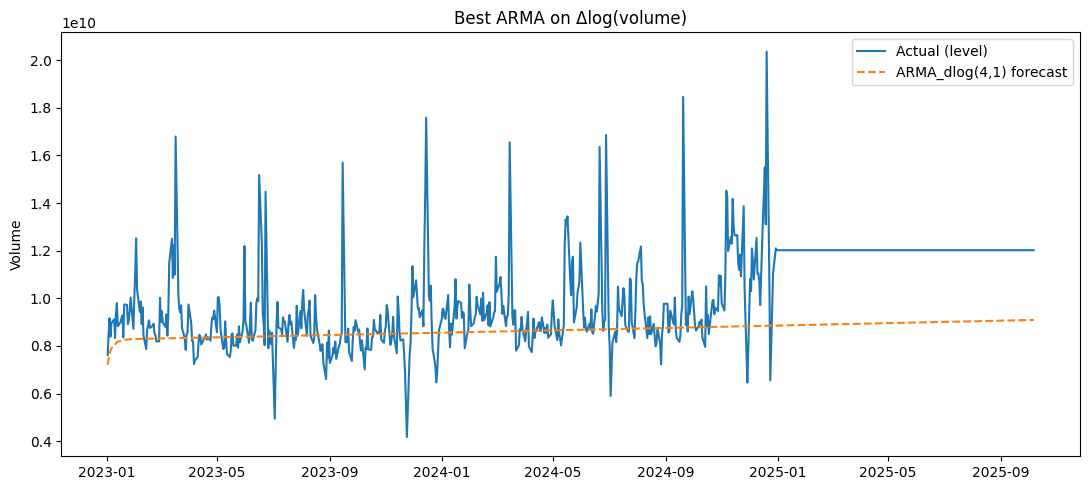

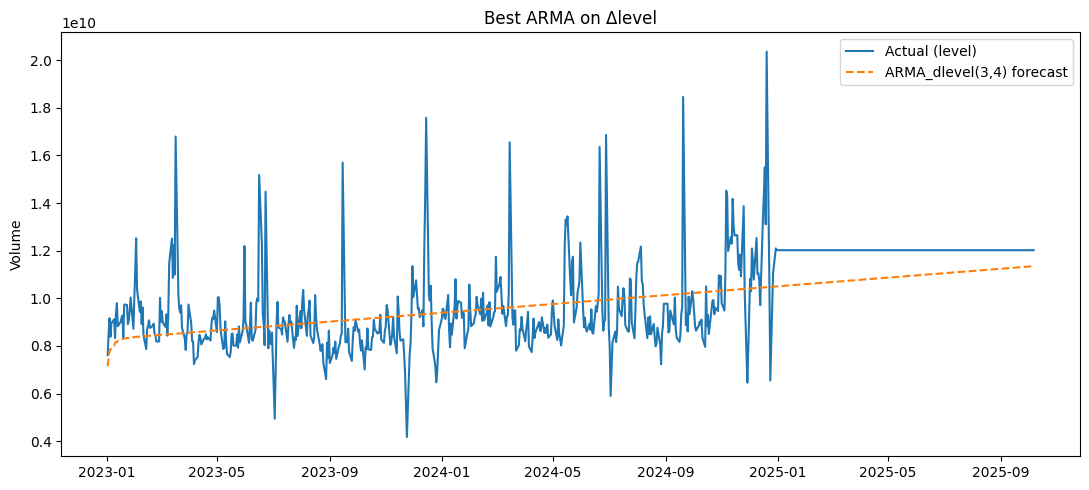

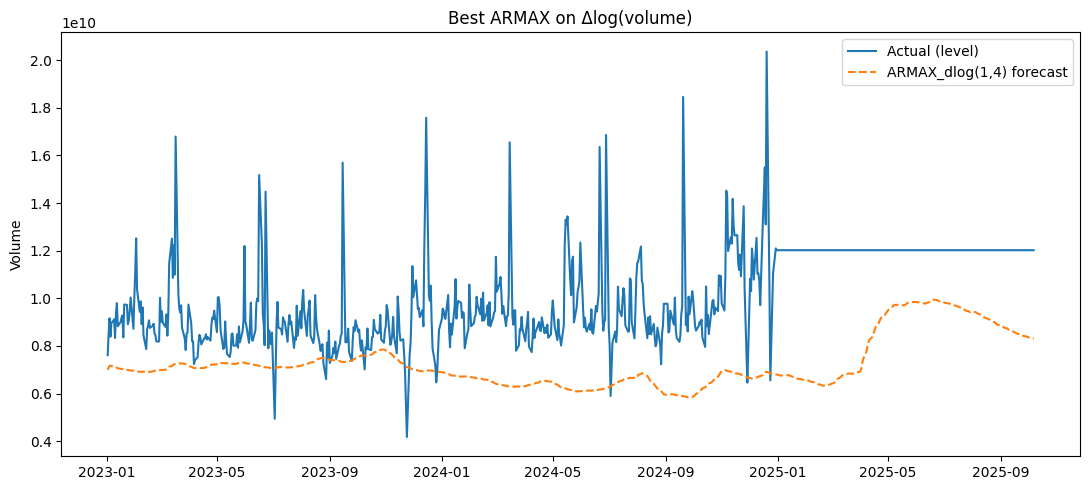

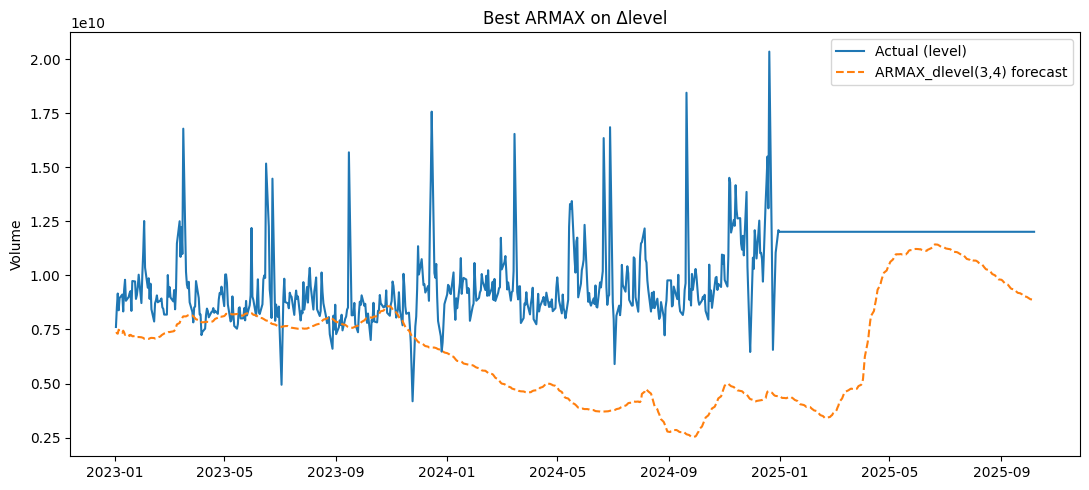

In [9]:
def plot_best(res_table, fc_dict, title):
    if res_table.empty: 
        print(f"{title}: (ingen resultater)"); return
    best_idx = res_table['AIC'].idxmin()
    p = int(res_table.loc[best_idx,'p']); q = int(res_table.loc[best_idx,'q'])
    level_pred, y_te_level = fc_dict[(p,q)]
    idx = test.index[:len(level_pred)]
    plt.figure(figsize=(11,5))
    plt.plot(idx, y_te_level.values, label="Actual (level)")
    plt.plot(idx, level_pred.values, label=f"{res_table.loc[best_idx,'model']} forecast", linestyle="--")
    plt.title(title); plt.ylabel("Volume"); plt.legend(); plt.tight_layout(); plt.show()

plot_best(arma_dlog_results, arma_dlog_fc, "Best ARMA on Δlog(volume)")
plot_best(arma_dlev_results, arma_dlev_fc, "Best ARMA on Δlevel")
try:
    plot_best(armax_dlog_results, armax_dlog_fc, "Best ARMAX on Δlog(volume)")
    plot_best(armax_dlev_results, armax_dlev_fc, "Best ARMAX on Δlevel")
except NameError:
    pass
